<a href="https://colab.research.google.com/github/CSpanias/spam_filter_bootcamp/blob/master/spam_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPAM FILTER**
*Author: [Charalampos Spanias](https://github.com/CSpanias)*

## This project was developed as an assignment for:
  * [Skills Bootcamp in Artificial Intelligence](https://instituteofcoding.org/skillsbootcamps/course/skills-bootcamp-in-artificial-intelligence/).

## This code is mainly based on: 
  * [Email Spam Detection Using Python & Machine Learning](https://www.youtube.com/watch?v=cNLPt02RwF0&list=WL&index=4&t=12s)
	

## It was modified based on:
  * [Spam or Ham tutorial](https://github.com/tejank10/Spam-or-Ham/blob/master/spam_ham.ipynb)

  * [SVM Classifier tutorial](https://www.kaggle.com/prashant111/svm-classifier-tutorial/notebook)

  * [Sololearn (Machine Learning path)](https://www.sololearn.com/learning/1094)

  * [Machine Learning for Absolute Beginners book](https://www.amazon.co.uk/Machine-Learning-Absolute-Beginners-Introduction-ebook/dp/B08RWBSKQB)

# **CONTENT**

1. [Data Cleaning](#DataCleaning)
2. [Object Manipulation (nltk)](#nltk)
3. [Naive-Bayes](#Naive-Bayes)
  * [Model Training](#modeltraining)
  * [Model Evaluation](#NB-Eval)
    1. [Accuracy Score](#AccuracyScore)
    2. [Null Accuracy](#NullAccuracy)
    3. [Classification Score](#ClassificationScore)
    4. [Confusion Matrix](#ConfusionMatrix)

4. [Support Vector Machine](#SVM)

  * [K-Fold Cross Validation](#K-Fold)
  * [Hyperparameter Optimization (GridSearchCV)](#GridSearchCV)
  * [Model Evaluation](#GS-Eval)
    1. Accuracy Score
    2. Classification Score
    4. Confusion Matrix
    5. ROC & AUC
5. [Results & Conclusions](#Res-Con)



Import the required libraries:
  1. ***pandas*** for importing dataset(*)
  2. ***matplotlib***, ***seaborn*** & ***IPython*** for visualisation
  3. ***string*** & ***nltk*** for object manipulation
  4. ***sklearn*** for machine learning
  5. ***wordcloud*** for wordcloud visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk

from nltk.corpus import stopwords
from wordcloud import WordCloud

from IPython.display import display

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

In [2]:
# read the CSV file
df = pd.read_csv('https://raw.githubusercontent.com/CSpanias/spam_filter_bootcamp/master/emails.csv')

# print the first 5 rows of data
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


<a name="DataCleaning"> </a>
# **Data Cleaning Process**

  * Duplicates
  * Missing values

In [3]:
# print the number of rows and columns
df.shape

(5728, 2)

In [4]:
# check for duplicates
df.duplicated().sum()

33

In [5]:
# remove duplicates
df.drop_duplicates(inplace=True)

In [6]:
# check for missing values
df.isna().sum()

text    0
spam    0
dtype: int64

<a name="nltk"> </a>
# **Object Manipulation Process**

  1. Remove punctuation from text
  2. Remove stopwords from text
  3. Split text in individual words

More info about nltk and Natural Language Processing (NLP) [here](https://www.nltk.org/book/?fbclid=IwAR1q2paswiXV1dMllJyKBxXmIVgbnes_KD3YKg4Kko6V_T4_nVXKjcYMyDE).

Define a function that:
  1. Removes punctuation symbols and stopwords from a text
  2. Splits the text into individual words
  3. Stores the individual words in a list

In [7]:
def process_text(text):
	"""
		Returns a list of strings (individual words) of a text (paragraph) excluding
		punctuation, stopwords.

			Parameters
			----------
				text: An object (string) variable.

			Returns
			-------
				clean_words: A list of objects (string).
		"""
	# create an empty list to later store the rows (emails) without punctuation
	no_punctuation = []
	# create an empty list to later store the words of each row (email)
	clean_words = []
	# for every row (email) in the text column
	for char in text:
		# remove every punctuation symbol
		if char not in string.punctuation:
			# append the free-of-punctuation row in the list "no_punctuation"
			no_punctuation.append(char)
	# insert an empty space between words
	no_punctuation = ''.join(no_punctuation)

	# for every row (email without punctuation symbols) in
	# the "no_punctuation" list split the text into words
	for word in no_punctuation.split():
		# convert every word in lowercase
		word = word.lower()
		# if this word is not a stopword
		if word not in stopwords.words('english'):
			# append the free-of-stopwords words in the list "clean_words"
			clean_words.append(word)
	# give back the list "clean_words"
	return clean_words

Apply the function "process_text" to the column "text" so we end up with a column of individual words and print the first 5 rows.

In [8]:
import nltk
nltk.download('stopwords')

df['text'].head().apply(process_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    [subject, naturally, irresistible, corporate, ...
1    [subject, stock, trading, gunslinger, fanny, m...
2    [subject, unbelievable, new, homes, made, easy...
3    [subject, 4, color, printing, special, request...
4    [subject, money, get, software, cds, software,...
Name: text, dtype: object

***CountVectorizer*** transforms a given text into a vector on the basis of 
the frequency (count) of each word that occurs in the entire text. 

More info on how it works [here](https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/).

In [9]:
# convert a collection of text to a matrix of tokens (*bow = bog of words)
messages_bow = CountVectorizer(analyzer=process_text).fit_transform(df['text'])

Create a **wordcloud visualisation** for the spam words.

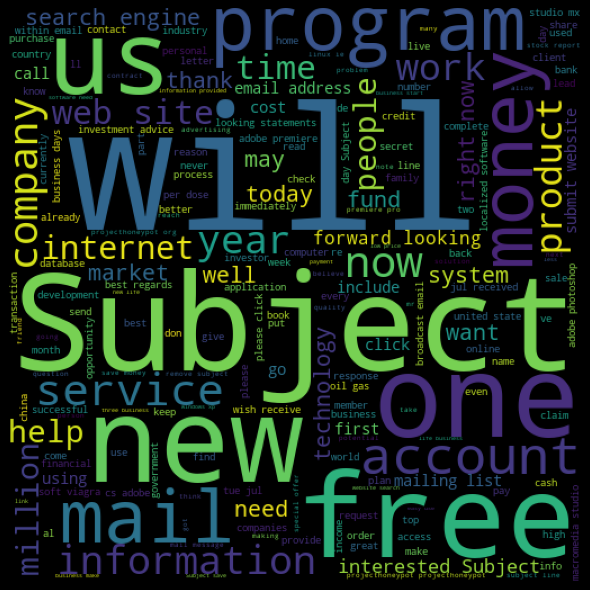

In [10]:
spam_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['text'][df['spam']==1]))
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<a name="training"> </a>
# **Model Training Process**

In [11]:
# assign X and y variables
X = messages_bow
y = df['spam']

# split data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=44,
                                                    shuffle=True)

In [12]:
# get the shape of X (rows, columns)
X.shape

(5695, 37228)

<a name="NaiveBayes"> </a>
# **Naive-Bayes**

Why Naive-Bayes?
  1. Binary classification task.
  2. Features are independent.

Which Naive-Bayes?
  1. **Multinomial** 
    * Assumes data is multinomially distributed.
    * Primarily used for document classification tasks based on ***word frequency***! Relevant?
  2. **Bernoulli**
    * Similar to Multinomial, but the features are ***independent Boolean variables***.
    * For example, if a word is present is not! More suitable for our task?
  3. **Complemenent** 
    * An adaptation of the multinomial naive Bayes algorithm that is particularly suited for ***imbalanced data sets***!

In [43]:
# choose how many train/test sets we want by "n_splits"
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=44)

# select the model(s)
model_mnb = MultinomialNB()
model_ber = BernoulliNB()
model_com = ComplementNB()

# train the model
model_mnb.fit(X_train, y_train)
model_ber.fit(X_train, y_train)
model_com.fit(X_train, y_train)

# calculate the accuracy score of each of the 5 train/test sets
mnb_scores = cross_val_score(model_mnb, X, y, cv=kfold)
ber_scores = cross_val_score(model_ber, X, y, cv=kfold)
com_scores = cross_val_score(model_com, X, y, cv=kfold)

# print average cross-validation scores
print('\nAverage stratified cross-validation score with Multinomial NB:',
      round(mnb_scores.mean(), 4))
print('Average stratified cross-validation score with Bernoulli NB:',
      round(ber_scores.mean(), 4))
print('Average stratified cross-validation score with Complement NB:',
      round(com_scores.mean(), 4))
print('')
# convert list of scores to dataframe
com_splits = pd.DataFrame(com_scores, columns = ['Individual splits for COM'])
# display dataframe as a table
display(com_splits)


Average stratified cross-validation score with Multinomial NB: 0.9902
Average stratified cross-validation score with Bernoulli NB: 0.9856
Average stratified cross-validation score with Complement NB: 0.99



,Individual splits for COM
0,0.984211
1,0.994737
2,0.987719
3,0.989474
4,0.989474
5,0.987698
6,0.987698
7,0.992970
8,0.992970
9,0.992970


<a name="NB-Eval"> </a>
# **Model Evalution**
1. Calculate **accuracy scores** with different variations of Naive-Bayes algorithm.

In [44]:
# check the prediction using Multinomial NB
print("Accuracy Score using Multinomial Naive-Bayes:\n")

# calculate accuracy score on training set
y_pred_train_mnb = model_mnb.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_mnb), 4))
# calculate accuracy score on test set
y_pred_test_mnb = model_mnb.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_mnb), 4))

# check the prediction using Bernoulli NB
print("\nAccuracy Score using Bernoulli Naive-Bayes:\n")
# calculate accuracy score on training set
y_pred_train_ber = model_ber.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_ber), 4))
# calculate accuracy score on test set
y_pred_test_ber = model_ber.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_ber), 4))

# check the prediction using Complement NB
print("\nAccuracy Score using Complement Naive-Bayes:\n")
# calculate accuracy score on training set
y_pred_train_com = model_com.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_com), 4))
# calculate accuracy score on test set
y_pred_test_com = model_com.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_com), 4))

Accuracy Score using Multinomial Naive-Bayes:

Training Set:  0.9969
Testing set:  0.9921

Accuracy Score using Bernoulli Naive-Bayes:

Training Set:  0.996
Testing set:  0.9895

Accuracy Score using Complement Naive-Bayes:

Training Set:  0.9971
Testing set:  0.9921


<a name="NullAccuracy"> </a>
2. Calculate **null accuracy** (*the accuracy that could be achieved by always predicting the most frequent class*) and compare it with the Complement Naive-Bayes model's accuracy.

  *A model that predicts everything as ham on a dataset with 9,900 ham and 100 spam emails will have: (9,900 / 10,000) = **0.99 accuracy**!*

In [ ]:
# check class distribution in test set
print(y_test.value_counts())
# check null accuracy score
null_accuracy = round(866/(866+273), 4)
print('Null accuracy score:', null_accuracy)

0    870
1    269
Name: spam, dtype: int64
Null accuracy score: 0.7603


Average CV testing accuracy with Complement Naive-Bayes: **0.9998** > Null accuracy: **0.7603.**.

<a name="ClassificationReport"> </a>
Calculate **Classification report** (*an overview of different scores*):

  * **Accuracy**: $\frac{CorrectlyPredicted}{Total}$ 
    * the simplest score
    * can be misleading as a sole metric
  
  * **Precision**: $\frac{TruePositives}{All Positives (TP+FP)}$ 
    * the ability of the classifier not to label as positive a sample that is negative
    * how precise is with its positive predictions.
 

  * **Recall/Sensitivity**: $\frac{TruePositive}{TruePositive + FalseNegative}$
    * the ability of the classifier to find all the positive samples  
    * how many of the positive cases can recall
  
  * **F1-score**: $2x\frac{PrecisionxRecall}{Precision+Recall}$
    * a weighted harmonic mean of the precision and recall 
  
  * **Support**:
    * the number of occurrences of each class in y_true

  * **Macro-average**: 
    * unweighted mean per label
  * **Weighted-average**: 
    * averaging the support-weighted mean per label

In [33]:
# print the classification report on the testing set with CNB
print("\n\t\t\tCLASSIFICATION REPORT\n\n",
      classification_report(y_test, y_pred_test_com))


			CLASSIFICATION REPORT

               precision    recall  f1-score   support

           0       1.00      0.99      0.99       870
           1       0.97      1.00      0.98       269

    accuracy                           0.99      1139
   macro avg       0.98      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139



<a name="ConfusionMatrix"> </a>
4. Generate & visualize the **Confusion Matrix**: describes how a model performs on a dataset.

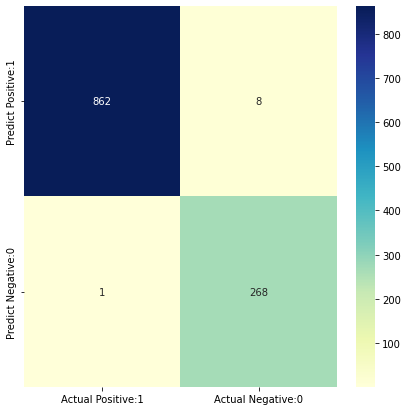

In [34]:
# generate a confusion matrix of the testing set with MNB
cm = confusion_matrix(y_test, y_pred_test_com)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])
fig, ax = plt.subplots(figsize=(7,7))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

* **Missclassifications**:
  * ***Only 1 spam email as ham***!
  * 8 ham emails as spam.

<a name="SVM"> </a>
# **Support Vector Machine**

* [K-Fold Cross Validation](#K-Fold)
* [Hyperparameter Optimization (GridSearchCV)](#GridSearchCV)
* [Model Evaluation](#GS-Eval)
* [Receiver Operating Characteristics (ROC) & Area Under the Curve (AUC)](#ROC-AUC)
* [Results & Conclusions](#Res-Con)

Why Support Vector Machine?
  1. Classification task with categorical outcome.

Why not SVM?
  1. Not recommended for datasets with low feature-to-row ratio!

<a name="K-Fold"></a>
# **K-Fold Cross-Validation**

**K-fold cross-validation** is a very useful technique to evaluate model 
performance. Instead of doing a single training-test split, we split our dataset multiple times.

The reasons behind K-Fold are:
  1. A certain split selected randomly at the start (*random_state=10*) may not be optimal. 
  2. The test set generated from that split is never used to evaluate the model.

But, it fails here because we have a ***imbalanced dataset***, so instead ***stratified k-fold cross-validation*** will be used. In the latter, the dataset is split such that the proportions between classes are the same in each fold as they are in the whole dataset.

In [ ]:
# choose how many train/test sets we want by "n_splits"
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# instantiate SVM model with default parameters
svc = SVC()

# calculate the accuracy score of each of the 5 train/test sets
svc_scores = cross_val_score(svc, X, y, cv=kfold)

# print cross-validation scores with SVM default parameters
print('Stratified cross-validation scores with SVM (default settings):\n'
'    Split 1    Split 2    Split 3    Split 4    Split 5\n', (svc_scores))

# print average cross-validation score with default parameteres
print('\nAverage stratified cross-validation score with default SVM:\n\n',
      round(svc_scores.mean(), 4))

# use cross_val_predict to generate K-Fold predictions
kf_predictions = cross_val_predict(svc, X, y, cv=10)

Stratified cross-validation scores with SVM (default settings):
    Split 1    Split 2    Split 3    Split 4    Split 5
 [0.976295   0.97980685 0.97278314 0.97278314 0.97366111]

Average stratified cross-validation score with default SVM:

 0.9751


In [ ]:
# select model with default parameters
svc_def = SVC()
# train the model with training data
svc_def.fit(X_train, y_train)
# use the model to predict test data
y_pred_def = svc_def.predict(X_test)
# calculate training accuracy
print(f'Training accuracy is: {round(accuracy_score(y_train, svc_def.predict(X_train)), 4)}')
# calculate testing accuracy
print(f'\nTesting accuracy is: {round(accuracy_score(y_test, y_pred_def), 4)}')

Training accuracy is: 0.9901

Testing accuracy is: 0.9728


<a name="GridSearchCV"></a>
**Hyperparameter Optimization Using GridSearchCV**

GridSearchCV has four parameters:
  1. The model
  2. Param_grid: a dictionary of the parameters names and all the possible values
  3. What metric to use (default is accuracy)
  4. How many folds for k-fold cross validation

More info about GridSearch [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

**Support Vector Machine Hyperparameters**:
  1. **C**: margin width, lower value = soft margin / high value = hard margin
  2. **kernels**: more info about kernel types [here](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).
  3. **gamma**: controls the influence of new Xs on the decision boundary, lower value = less/ higher value = more.

More info about SVM parameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [ ]:
# instantiate classifier with default parameters (kernel='rbf', C=1.0, gamma='scale')
svc = SVC(class_weight='balanced')

# declare parameters for hyperparameter tuning
params = [
          {'C': [0.1, 1, 10], 'kernel':['linear']},
          {'C': [0.1, 1, 10], 'kernel': ['poly'], 'degree': [2,3], 
           'gamma': [0.05, 0.09]}
          ]

# create a dictionary for multiple scoring
scoring = {
            "Accuracy": make_scorer(accuracy_score),
            "f1-score": make_scorer(f1_score)
           }

# create the grid search object
gs = GridSearchCV(svc, params, scoring=scoring, cv=5, return_train_score=True, refit='f1-score', n_jobs=1, verbose=3)

# fit the gs object
gs.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END C=0.1, kernel=linear; Accuracy: (train=1.000, test=0.984) f1-score: (train=1.000, test=0.966) total time=   2.2s
[CV 2/5] END C=0.1, kernel=linear; Accuracy: (train=1.000, test=0.980) f1-score: (train=1.000, test=0.959) total time=   2.2s
[CV 3/5] END C=0.1, kernel=linear; Accuracy: (train=1.000, test=0.986) f1-score: (train=1.000, test=0.971) total time=   2.0s
[CV 4/5] END C=0.1, kernel=linear; Accuracy: (train=1.000, test=0.984) f1-score: (train=1.000, test=0.966) total time=   2.1s
[CV 5/5] END C=0.1, kernel=linear; Accuracy: (train=1.000, test=0.993) f1-score: (train=1.000, test=0.987) total time=   2.1s
[CV 1/5] END C=1, kernel=linear; Accuracy: (train=1.000, test=0.981) f1-score: (train=1.000, test=0.961) total time=   2.2s
[CV 2/5] END C=1, kernel=linear; Accuracy: (train=1.000, test=0.977) f1-score: (train=1.000, test=0.952) total time=   2.0s
[CV 3/5] END C=1, kernel=linear; Accuracy: (train=1.000, test

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_jobs=1,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10], 'degree': [2, 3],
                          'gamma': [0.05, 0.09], 'kernel': ['poly']}],
             refit='f1-score', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'f1-score': make_scorer(f1_score)},
             verbose=3)

<a name="GS-Eval"></a>
# **Model Evaluation**

Assess the hyperparameter optimization with GridSearch for Support Vector Machine.

* The **best_score_** attribute gives the **training mean cross-validation score**.
* The **score method** on the test-set gives the **testing mean cross-validation score**, i.e. the **generalization performance of the model**.

In [ ]:
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search:', gs.best_estimator_)

# get the model with the mean cross-validation training accuracy
print('\nMean cross-validation training accucary:', (round(gs.best_score_, 4)))

# calculate GridSearch CV score
print('\nMean cross-validation testing accuracy score:', round(gs.score(X_test, y_test), 4))


Estimator that was chosen by the search: SVC(C=0.1, class_weight='balanced', kernel='linear')

Mean cross-validation training accucary: 0.9696

Mean cross-validation testing accuracy score: 0.9797


Train the model proposed by GridSeachCV.

In [ ]:
# select the model proposed by GridSearchCV
model = SVC(C=0.1, class_weight='balanced', kernel='linear')

# train the model
model.fit(X_train, y_train)

# calculate training accuracy
y_pred_train = model.predict(X_train)
# predict using the test data
y_pred = model.predict(X_test)

# calculate accuracy
print("Training accuracy: {:.4f}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score: {:.4f}".format(accuracy_score(y_test, y_pred)))

Training accuracy: 1.0000
Accuracy score: 0.9903


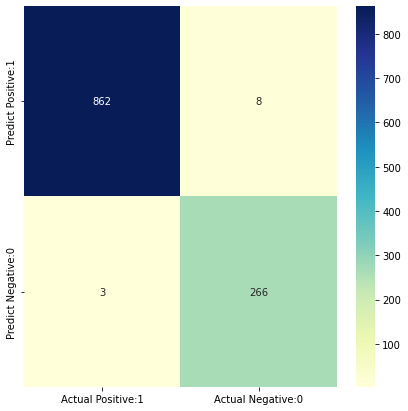

In [ ]:
# generate a confusion matrix of the testing set with MNB
cm = confusion_matrix(y_test, y_pred)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])
fig, ax = plt.subplots(figsize=(7,7))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<a name="ROC-AUC"></a>
## **Receiver Operating Characteristics** (ROC) & **Area Under the Curve** (AUC)

1. **ROC**: a graph showing all of the possible models and their performance, a "general sense" how our model is performing on the dataset.
2. **AUC**: the bigger the area, the better the model.

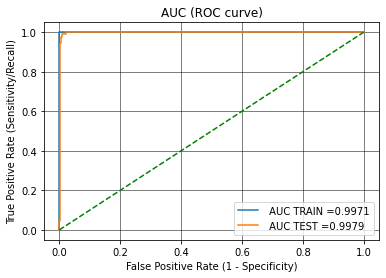

In [ ]:
y_train_pred = model.decision_function(X_train)    
y_test_pred = model.decision_function(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

# calculate cross-validated ROC & AUC for training data
auc_train = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
# take the mean score of the 5 splits
auc_train = auc_train.mean()
# round the result to 4 decimal digits
auc_train = round(auc_train, 4)

# calculate ROC & AUC for testing data
auc_test = roc_auc_score(y_test, y_test_pred)
# round the result to 4 decimal digits
auc_test = round(auc_test, 4)

# visualize ROC & AUC
plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc_train))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc_test))
# draw a line
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.title('AUC (ROC curve)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(color='black', linestyle='-', linewidth=0.5)

<a name="Res-Con"></a>
# **Results and Conclusions**

1. **Multinomial Naive-Bayes** had a testing accuracy of **99.1%**, far better than **null accuracy** (76%).

  Training the Multinomial Naive-Bayes model was done **instantly** and without **any optimization**.

2. **SVC with default settings** (*kernel='rbf', C=1.0*) had a test accuracy of **97.5%**, while with **GridSearch CV** hyperparameter optimization SVC with modified settings (*kernel='linear', C=10.0*) had a test accuracy of **99.1%**. So, GridSearch CV was successful in identifying the parameters that will improve the performance for this particular model.

  The GridSearchCV optimization took **17 minutes** and still produced the same accuracy with Multinomial Naive-Bayes!